In [309]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score
import os


In [ ]:
# Set workspace
workspace_path = r"C:\Users\kaefer\Desktop\Schulemappe\Master\MasterEBusiness\E Business Seminar\NAB-master"
os.chdir(workspace_path)
print(f"Current working directory: {os.getcwd()}")

Current working directory: C:\Users\kaefer\Desktop\Schulemappe\Master\MasterEBusiness\E Business Seminar\NAB-master


In [ ]:
#Load Dataset
path = "data//artificialNoAnomaly//art_daily_small_noise.csv"
df = pd.read_csv(path)
time = df['timestamp']
demand = df['value'].values
df


,timestamp,value
0,2014-04-01 00:00:00,18.324919
1,2014-04-01 00:05:00,21.970327
2,2014-04-01 00:10:00,18.624806
3,2014-04-01 00:15:00,21.953684
4,2014-04-01 00:20:00,21.909120
...,...,...
4027,2014-04-14 23:35:00,20.211195
4028,2014-04-14 23:40:00,20.531041
4029,2014-04-14 23:45:00,19.032127
4030,2014-04-14 23:50:00,21.798801


In [ ]:
#Normalize Data for LSTM
scaler = MinMaxScaler()
df["scaled_value"] = scaler.fit_transform(df[["value"]])

In [ ]:
#Prepare Data for LSTM (Convert to Sequences)
sequence_length = 10  # Lookback window
X, y = [], []
for i in range(len(df) - sequence_length):
    X.append(df["scaled_value"].iloc[i:i + sequence_length].values)
    y.append(df["scaled_value"].iloc[i + sequence_length])

X, y = np.array(X), np.array(y)

In [ ]:
#Train LSTM Model
model = Sequential([
    LSTM(50, activation="relu", return_sequences=False, input_shape=(sequence_length, 1)),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse")
model.fit(X, y, epochs=50, batch_size=8, verbose=0)

C:\Users\kaefer\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#Forecast Future Values
predictions = model.predict(X)
df["forecast"] = np.nan
df.iloc[sequence_length:, df.columns.get_loc("forecast")] = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()

126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
#Anomaly Detection Smoothed (ZScore) Values**
# Dynamically set on smoothed datas interquartile range
'''q1, q3 = df["forecast"].quantile([0.376048, 0.624052]) #([0.374977, 0.625023])
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr
lower_bound = q1 - 1.5 * iqr

# Estimate new contamination based on extreme values 
new_contamination = np.mean((df["forecast"] < lower_bound) | (df["forecast"] > upper_bound))
print(new_contamination)
new_contamination = max(0.01, min(new_contamination, 0.5))'''

iso_forest = IsolationForest(contamination=0.05, random_state=42)
df["anomaly"] = iso_forest.fit_predict(df[["forecast"]]) == -1

#q1, q3, iqr, upper_bound, lower_bound


In [ ]:
#Mitigate Anomalies Average Smoothing
window_size = 7
df["smoothed_value"] = df["value"].rolling(window=window_size, center=True).mean()

#df["smoothed_value"] = df["forecast"].ewm(span=10, adjust=False).mean() # bigger smoothing factor

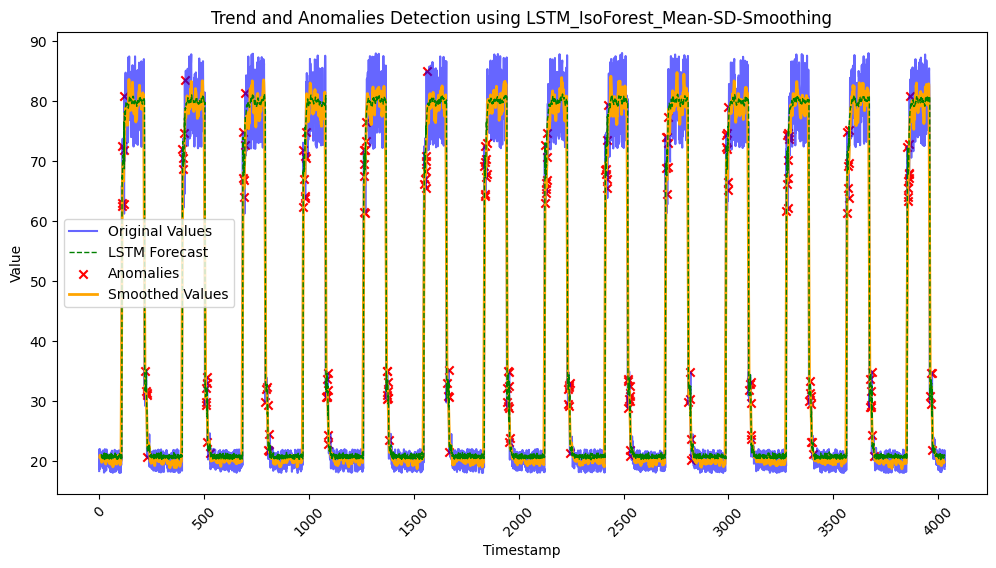

In [ ]:
#Plot Results
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["value"], label="Original Values", color="blue", alpha=0.6)
plt.plot(df.index, df["forecast"], label="LSTM Forecast", linestyle="dashed", color="green",zorder = 3,linewidth=1)
plt.scatter(df.index[df["anomaly"]], df["value"][df["anomaly"]], color="red", label="Anomalies", marker="x")
plt.plot(df.index, df["smoothed_value"], label="Smoothed Values", color="orange", linewidth=2)
plt.legend()
plt.title("Trend and Anomalies Detection using LSTM_IsoForest_Mean-SD-Smoothing")
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.xticks(rotation=45)
plt.show()


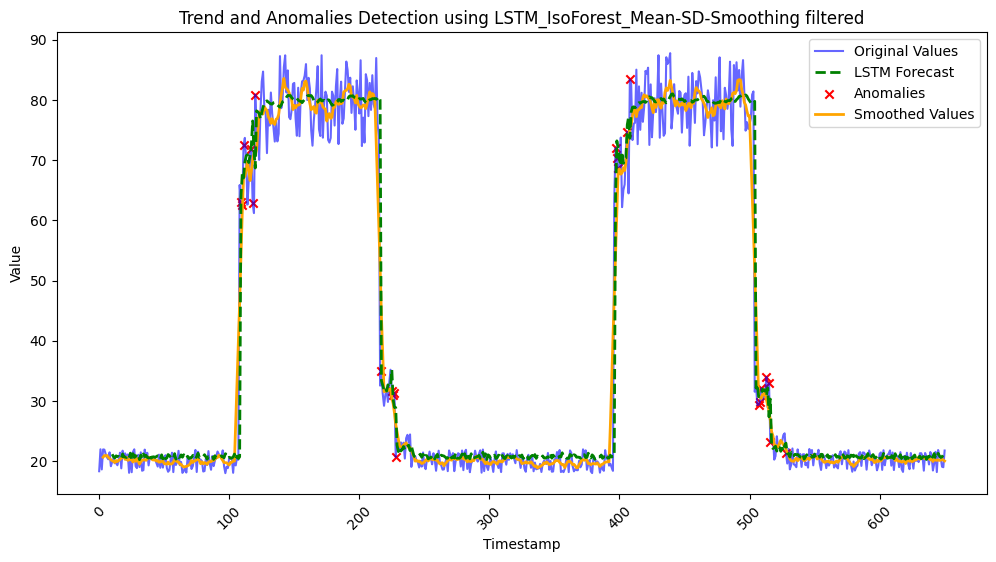

In [319]:
# Filter the dataset for the specific date range
df_filtered = df.iloc[0:651]

# Plot only the filtered date range
plt.figure(figsize=(12, 6))
plt.plot(df_filtered.index, df_filtered["value"], label="Original Values", color="blue", alpha=0.6)
plt.plot(df_filtered.index, df_filtered["forecast"], label="LSTM Forecast", linestyle="dashed", color="green", zorder=3, linewidth=2)
plt.scatter(df_filtered.index[df_filtered["anomaly"]], df_filtered["value"][df_filtered["anomaly"]], color="red", label="Anomalies", marker="x")
plt.plot(df_filtered.index, df_filtered["smoothed_value"], label="Smoothed Values", color="orange", linewidth=2)
plt.legend()
plt.title("Trend and Anomalies Detection using LSTM_IsoForest_Mean-SD-Smoothing filtered")
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.xticks(rotation=45)
plt.show()

In [320]:
print(df[df["anomaly"] == True])
print(len(df[df["anomaly"] == True]))

                timestamp      value  scaled_value   forecast  anomaly  \
109   2014-04-01 09:05:00  63.030237      0.643504  63.896896     True   
110   2014-04-01 09:10:00  62.484097      0.635699  67.707733     True   
111   2014-04-01 09:15:00  72.508649      0.778958  67.048180     True   
117   2014-04-01 09:45:00  71.805564      0.768910  72.466934     True   
118   2014-04-01 09:50:00  62.807773      0.640324  76.504868     True   
...                   ...        ...           ...        ...      ...   
3961  2014-04-14 18:05:00  30.814977      0.183122  30.183813     True   
3966  2014-04-14 18:30:00  34.613994      0.237413  33.388084     True   
3967  2014-04-14 18:35:00  29.468668      0.163882  33.711384     True   
3971  2014-04-14 18:55:00  34.704457      0.238706  27.500864     True   
3973  2014-04-14 19:05:00  21.789489      0.054141  22.798920     True   

      smoothed_value  
109        54.065838  
110        61.119680  
111        67.174022  
117        68.15628

In [321]:
#complet neue froecasting mit neuen werten

In [ ]:
#Normalize Data for LSTM
scaler = MinMaxScaler()
df["scaled_value_smoothed"] = scaler.fit_transform(df[["smoothed_value"]])

In [ ]:
#Prepare Data for LSTM (Convert to Sequences)
sequence_length = 10  # Lookback window
X, y = [], []
for i in range(len(df) - sequence_length):
    X.append(df["scaled_value_smoothed"].iloc[i:i + sequence_length].values)
    y.append(df["scaled_value_smoothed"].iloc[i + sequence_length])

X, y = np.array(X), np.array(y)


In [ ]:
#Forecast Future Values
predictions = model.predict(X)
df["forecast_smoothed"] = np.nan
df.iloc[sequence_length:, df.columns.get_loc("forecast_smoothed")] = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()

126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step


In [ ]:
#Define and Train LSTM Model
model = Sequential([
    LSTM(50, activation="relu", return_sequences=False, input_shape=(sequence_length, 1)),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse")
model.fit(X, y, epochs=50, batch_size=8, verbose=0)


C:\Users\kaefer\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#Anomaly Detection Smoothed (ZScore) Values**
# Dynamically set on smoothed datas interquartile range
'''q1, q3 = df["forecast_smoothed"].quantile([0.376048, 0.624052])
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr
lower_bound = q1 - 1.5 * iqr

# Estimate new contamination based on how many extreme values exist
new_contamination = np.mean((df["forecast_smoothed"] < lower_bound) | (df["forecast_smoothed"] > upper_bound))
new_contamination = max(0.01, min(new_contamination, 0.5))'''

iso_forest = IsolationForest(contamination=0.05, random_state=42)
df["smoothed_anomaly"] = iso_forest.fit_predict(df[["forecast_smoothed"]]) == -1



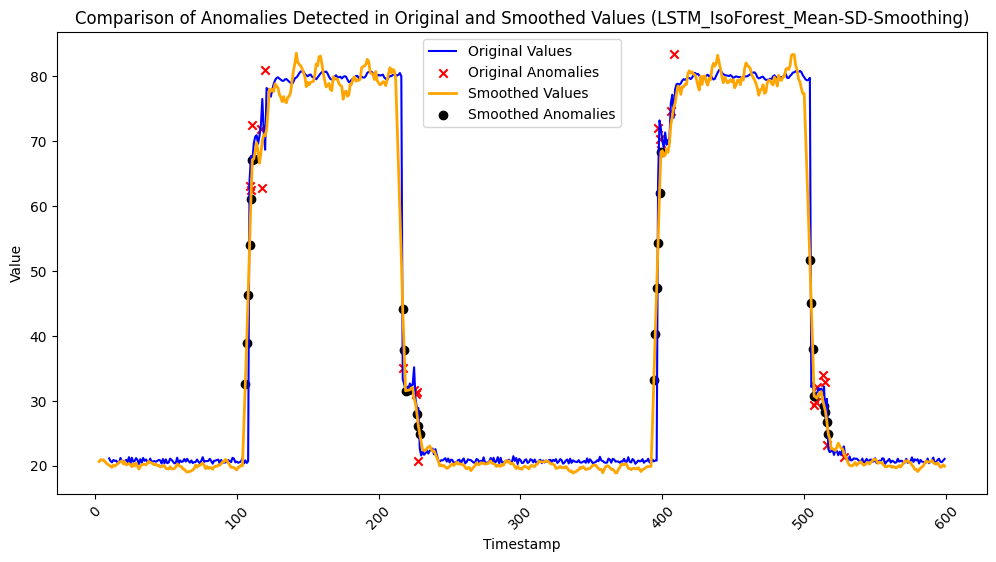

Original Anomalies Detected: 202
Smoothed Anomalies Detected: 198
Anomalies Reduced: 4


In [ ]:
df_filtered_comp = df.iloc[0:600]

plt.figure(figsize=(12, 6))

plt.plot(df_filtered_comp.index, df_filtered_comp["forecast"], label="Original Values", color="blue", alpha=1)
plt.scatter(df_filtered_comp.index[df_filtered_comp["anomaly"]], df_filtered_comp["value"][df_filtered_comp["anomaly"]], color="red", label="Original Anomalies", marker="x")

plt.plot(df_filtered_comp.index, df_filtered_comp["smoothed_value"], label="Smoothed Values", color="orange", linewidth=2, zorder=3)
plt.scatter(df_filtered_comp.index[df_filtered_comp["smoothed_anomaly"]], df_filtered_comp["smoothed_value"][df_filtered_comp["smoothed_anomaly"]], color="black", label="Smoothed Anomalies", marker="o")

plt.title("Comparison of Anomalies Detected in Original and Smoothed Values (LSTM_IsoForest_Mean-SD-Smoothing)")
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.legend()
plt.xticks(rotation=45)
plt.show()

original_anomalies_count = df["anomaly"].sum()
smoothed_anomalies_count = df["smoothed_anomaly"].sum()

print(f"Original Anomalies Detected: {original_anomalies_count}")
print(f"Smoothed Anomalies Detected: {smoothed_anomalies_count}")
print(f"Anomalies Reduced: {original_anomalies_count - smoothed_anomalies_count}")

In [328]:
original_variance = np.var(df["value"])
smoothed_variance = np.var(df["smoothed_value"])

print(f"Original Variance: {original_variance:.4f}")
print(f"Smoothed Variance: {smoothed_variance:.4f}")
print(f"Variance Reduction: {original_variance - smoothed_variance:.4f}")

Original Variance: 788.1293
Smoothed Variance: 761.5466
Variance Reduction: 26.5827
